# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [234]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
import collections
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [107]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv ('AZDIAS_Feature_Summary.csv', sep = ';')

In [108]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).




In [109]:
azdias.shape

(891221, 85)

In [110]:
azdias.head(4)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0


In [111]:
feat_info.shape

(85, 4)

In [112]:
feat_info.head(4)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [113]:
# Identify missing or unknown data values and convert them to NaNs.
nat_miss = azdias.isnull().sum()
nat_miss

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [114]:
feat_info.dtypes


attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object

In [115]:
azdias.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
          

In [116]:
def define_missing(string):
    def_missing = string.replace('[', '').replace(']', '').split(',')

    if(def_missing != None):
        for i in range(len(def_missing)):
            try: def_missing[i] = int(def_missing[i])
            except ValueError: continue #we are trying to convert string to int ie int('XX') -> error  

    return def_missing

In [117]:
for col in azdias:
    missing_rep = define_missing(feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0])
    
    if(missing_rep[0] == ''): 
        azdias[col] = azdias[col].replace('', np.nan)
        i+=1
        continue
    i=0
    replace_with = list(np.nan for i in missing_rep) #create list of None same length as missing_rep
    azdias[col] = azdias[col].replace(missing_rep, replace_with);

In [118]:
new_miss = azdias.isnull().sum()
new_miss

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

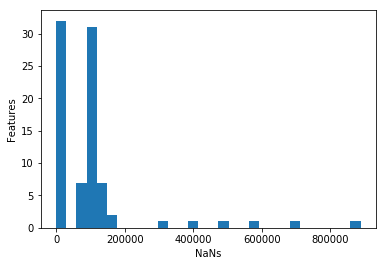

In [119]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_count = np.asarray(azdias.isnull().sum().tolist())
plt.hist(null_count, bins=30)
plt.xlabel("NaNs")
plt.ylabel('Features')
plt.show()



In [120]:
# Investigate patterns in the amount of missing data in each column.
azdias.isnull().sum().describe()


count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [121]:
# there are 6 columns with more than 200000 nans, they are our outliers

In [122]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
pre_shape = azdias.shape
labels_to_clean = []
for col in azdias:
    if(azdias[col].isnull().sum()>200000):
        labels_to_clean.append(col)
azdias_cleaned = azdias.drop(labels_to_clean, axis=1)
new_shape = azdias_cleaned.shape

In [123]:
pre_shape

(891221, 85)

In [124]:
new_shape

(891221, 79)

In [125]:
# We have gotten rid of our 6 outlier columns

#### Discussion 1.1.2: Assess Missing Data in Each Column

1- There were 6 columns, namely "AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX" which had more than 200000 nans, so they were dropped.

2- What columns(names) have same number of missing values? Following columns have the same number of missing values:
LP_FAMILIE_FEIN 77792 LP_FAMILIE_GROB 77792,
LP_STATUS_FEIN 4854 LP_STATUS_GROB 4854,
OST_WEST_KZ 93148 WOHNLAGE 93148,
CAMEO_DEUG_2015 99352 CAMEO_DEU_2015 99352 CAMEO_INTL_2015 99352,
KBA05_ANTG1 133324 KBA05_ANTG2 133324 KBA05_ANTG3 133324 KBA05_ANTG4 133324,
##### It is clear from the above observation that there might be a sense of correlation between theses columns, it will be interesting to investigate further on this.


3- Which columns have no missing values? Following columns have no missing values: 
FINANZ_MINIMALIST,
FINANZ_SPARER,
FINANZ_VORSORGER,
FINANZ_ANLEGER,
FINANZ_UNAUFFAELLIGER,
FINANZ_HAUSBAUER,
FINANZTYP,
SEMIO_SOZ,
SEMIO_FAM,
SEMIO_REL,
SEMIO_MAT,
SEMIO_VERT,
SEMIO_LUST,

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [126]:
# How much data is missing in each row of the dataset?
miss_row = pd.DataFrame(azdias_cleaned.isnull().sum (axis = 1), columns = ['nans_in_rows'])
miss_row


,nans_in_rows
0,43
1,0
2,0
3,7
4,0
5,0
6,0
7,0
8,0
9,0


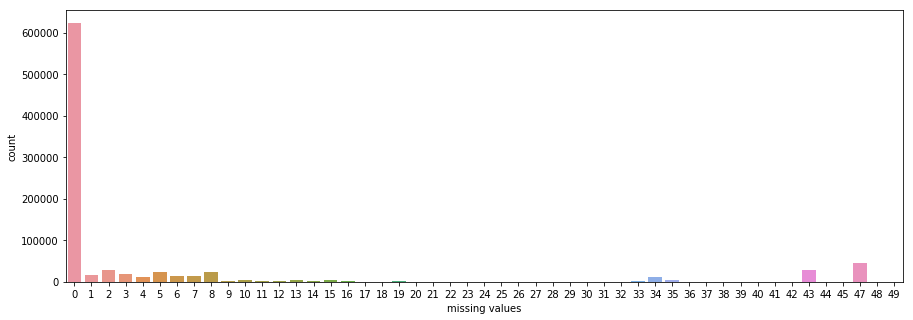

In [127]:
plt.figure(figsize=(15,5))
ax = sns.countplot(azdias_cleaned.isnull().sum(axis=1))
ax.set_xlabel('missing values')
plt.show()

In [128]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.  
azdias_cleaned['missing_in_rows'] = miss_row['nans_in_rows']
azdias_1 = azdias_cleaned [ azdias_cleaned ['missing_in_rows'] <=20]
azdias_2 = azdias_cleaned [ azdias_cleaned ['missing_in_rows'] >20]



In [129]:
azdias_1.shape

(797426, 80)

In [130]:
azdias_2.shape

(93795, 80)

In [131]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias_1_withoutnan = azdias_1[azdias_1.columns[~azdias_1.isnull().any()]]
azdias_2_withoutnan = azdias_2[azdias_2.columns[~azdias_2.isnull().any()]]



In [132]:
azdias_1_withoutnan.isnull().sum()

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
ZABEOTYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
WOHNDAUER_2008           0
GEBAEUDETYP              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
WOHNLAGE                 0
missing_in_rows          0
dtype: int64

In [133]:
azdias_2_withoutnan.isnull().sum()

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
missing_in_rows          0
dtype: int64

In [134]:
def comp_func (df1, df2, column):
    fig, ax =plt.subplots(1,2)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column], ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return 

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


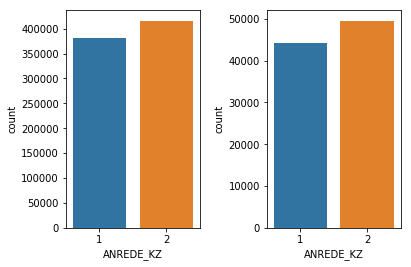

In [135]:
comp_func (azdias_1, azdias_2, 'ANREDE_KZ')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


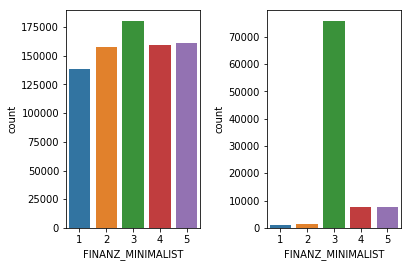

In [136]:
comp_func (azdias_1, azdias_2, 'FINANZ_MINIMALIST')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


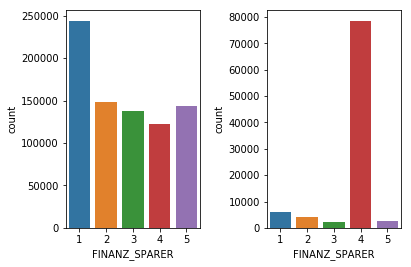

In [137]:
comp_func (azdias_1, azdias_2, 'FINANZ_SPARER')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


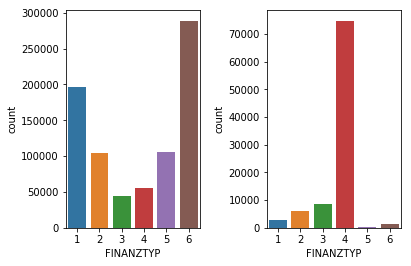

In [138]:
comp_func (azdias_1, azdias_2, 'FINANZTYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


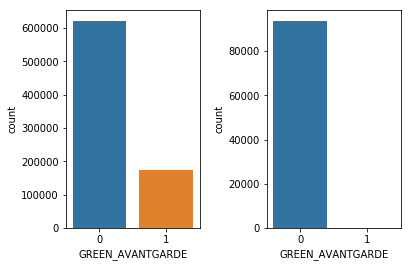

In [139]:
comp_func (azdias_1, azdias_2, 'GREEN_AVANTGARDE')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


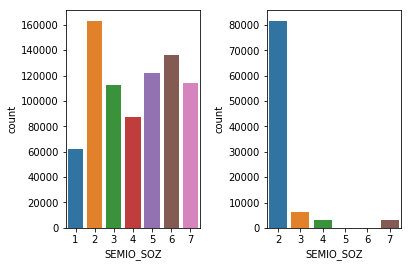

In [140]:
comp_func (azdias_1, azdias_2, 'SEMIO_SOZ')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


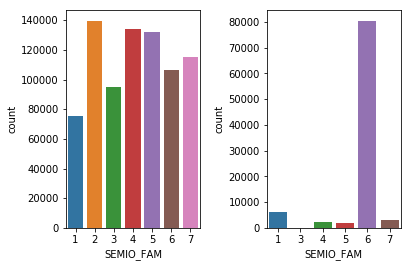

In [141]:
comp_func (azdias_1, azdias_2, 'SEMIO_FAM')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


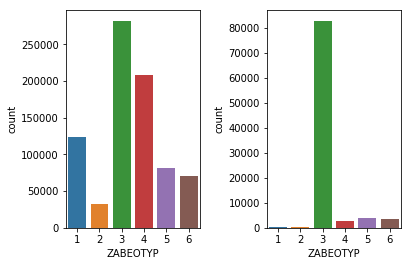

In [142]:
comp_func (azdias_1, azdias_2, 'ZABEOTYP')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Dataset can be divided into 2 big subsets: missing less or equal to 20 values in a row and missing more than 20 values in a row where majority is for less than 20.

I looked at 8 features where the data had no missing values, and quite interestingly most of the features had a very different distribution of values in both the datasets.

The highest difference in distributions was seen in the columns:

SEMIO_FAM, SEMIO_SOZ, FINANZTYP

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [143]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [144]:
# How many features are there of each data type?
feat_info['type'].value_counts()



ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [145]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_feat = feat_info [ feat_info ['type'] =='categorical']
cat_feat


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [146]:
x =(cat_feat['attribute']).tolist()
type(x)
azdias_cleaned[[c for c in azdias_cleaned.columns if c in x]]

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1,2.0,4,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C
6,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4,1.0,W,4,4A
7,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,8.0,W,2,2D
8,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6,3.0,W,1,1A
9,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4,3.0,W,1,1E


In [162]:
azdias_1['OST_WEST_KZ'].value_counts()

W    628987
O    168439
Name: OST_WEST_KZ, dtype: int64

In [167]:
azdias_1.OST_WEST_KZ = azdias_1.OST_WEST_KZ.replace ({'O': 0.0,
                                                            'W': 1.0}) 

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [168]:
for column in (cat_feat ['attribute']):
    print (column) 

AGER_TYP
ANREDE_KZ
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [169]:
# Re-encode categorical variable(s) to be kept in the analysis.
list_enc = [] 

for column in (cat_feat ['attribute']):
    if column in azdias_1.columns:
        print (column) #printing feature name
        unv = azdias_1 [column].unique () #returns list of unique values
        display (unv)
        if unv.size > 1: #we only need features containing more than 2 possible values
            list_enc.append (column)

ANREDE_KZ


array([2, 1])

CJT_GESAMTTYP


array([  5.,   3.,   2.,   4.,   1.,   6.,  nan])

FINANZTYP


array([1, 6, 5, 2, 4, 3])

GFK_URLAUBERTYP


array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   2.,   7.,
         6.,  nan])

GREEN_AVANTGARDE


array([0, 1])

LP_FAMILIE_FEIN


array([  5.,   1.,  nan,  10.,   2.,   7.,  11.,   8.,   4.,   6.,   9.,
         3.])

LP_FAMILIE_GROB


array([  3.,   1.,  nan,   5.,   2.,   4.])

LP_STATUS_FEIN


array([  2.,   3.,   9.,   4.,   1.,  10.,   5.,   8.,   6.,   7.,  nan])

LP_STATUS_GROB


array([  1.,   2.,   4.,   5.,   3.,  nan])

NATIONALITAET_KZ


array([  1.,   3.,   2.,  nan])

SHOPPER_TYP


array([  3.,   2.,   1.,   0.,  nan])

SOHO_KZ


array([ 1.,  0.])

VERS_TYP


array([  2.,   1.,  nan])

ZABEOTYP


array([5, 3, 4, 1, 6, 2])

GEBAEUDETYP


array([ 8.,  1.,  3.,  2.,  6.,  4.,  5.])

OST_WEST_KZ


array([ 1.,  0.])

CAMEO_DEUG_2015


array(['8', '4', '2', '6', '1', '9', '5', '7', nan, '3'], dtype=object)

CAMEO_DEU_2015


array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', nan, '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [170]:
print (list_enc)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [171]:
azdias_3 = pd.get_dummies (azdias_1, columns = list_enc)
print (azdias_3.shape)
display (list (azdias_3.columns))

(797426, 200)


['ALTERSKATEGORIE_GROB',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEI

#### Discussion 1.2.1: Re-Encode Categorical Features
For all binary and multi-level categorical features, I have used one hot encoding.
I did not drop any feature beacause I did not want to lose any important feature



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [175]:
cat_feat_mix = feat_info [ feat_info['type'] =='mixed']
cat_feat_mix

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [178]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_3['PRAEGENDE_JUGENDJAHRE'].value_counts()


14.0    182903
8.0     141542
10.0     85767
5.0      84665
3.0      53822
15.0     42521
11.0     35735
9.0      33563
6.0      25651
12.0     24440
1.0      20662
4.0      20450
2.0       7479
13.0      5759
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [180]:
azdias_3 ['PRAEGENDE_JUGENDJAHRE_AM'] = azdias_3 ['PRAEGENDE_JUGENDJAHRE']

azdias_3 ['PRAEGENDE_JUGENDJAHRE_DC'] = azdias_3 ['PRAEGENDE_JUGENDJAHRE']

In [181]:

dict1 =                                                                        {1: 40.0,
                                                                                2: 40.0,
                                                                                3: 50.0,
                                                                                4: 50.0,
                                                                                5: 60.0,
                                                                                6: 60.0,
                                                                                7: 60.0,
                                                                                8: 70.0,
                                                                                9: 70.0,
                                                                                10: 80.0,
                                                                                11: 80.0,
                                                                                12: 80.0,
                                                                                13: 80.0,
                                                                                14: 90.0, 
                                                                                15: 90.0,
                                                                                }


#replacing with decade values
azdias_3.PRAEGENDE_JUGENDJAHRE_DC = azdias_3.PRAEGENDE_JUGENDJAHRE_DC.replace (dict1)  


#replacing where Mainstream encoded as 0 and avantgarde as 1
dict2 =                                                                        {1: 0.0,
                                                                                2: 1.0,
                                                                                3: 0.0,
                                                                                4: 1.0,
                                                                                5: 0.0,
                                                                                6: 1.0,
                                                                                7: 1.0,
                                                                                8: 0.0,
                                                                                9: 1.0,
                                                                                10: 0.0,
                                                                                11: 1.0,
                                                                                12: 0.0,
                                                                                13: 1.0,
                                                                                14: 0.0, 
                                                                                15: 1.0,
                                                                                }

azdias_3.PRAEGENDE_JUGENDJAHRE_AM = azdias_3.PRAEGENDE_JUGENDJAHRE_AM.replace (dict2)  

In [182]:
azdias_3.head(5)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,0,0,0,0,0,0,0,0.0,90.0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,0,0,0,0,0,1.0,90.0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,70.0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,0,0,0,0,0,0.0,70.0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,1,0,0,0,0,0,0,0.0,50.0


In [183]:
azdias_3[['CAMEO_INTL_2015']]

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54
6,22
7,14
8,13
9,15
10,51


In [192]:
#It appears that "CAMEO_INTL_2015" should be devided into 2 variables: wealth and life stage

#Wealth can be coded as (in the new column CAMEO_INTL_2015_WL): 
#Wealthy Households: 1
#Prosperous Households: 2
#Comfortable Households: 3
#Less Affluent Households: 4
#Poorer Households: 5

#Life stage as (in new column CAMEO_INTL_2015_LS): 
#Pre-Family: 0
#Young Couples: 1
#Families: 2
#Older Families: 3 
#Elders: 4

#Let's copy column "CAMEO_INTL_2015" to a new column: CAMEO_INTL_2015_LS
azdias_3 ['CAMEO_INTL_2015_LS'] = azdias_3 ['CAMEO_INTL_2015']
azdias_3 ['CAMEO_INTL_2015_WL'] = azdias_3 ['CAMEO_INTL_2015']

In [193]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#replacing with wealth codes
dict3 = {'11': 1.0,
                                                                                '12': 1.0,
                                                                                '13': 1.0,
                                                                                '14': 1.0,
                                                                                '15': 1.0,
                                                                                '21': 2.0,
                                                                                '22': 2.0,
                                                                                '23': 2.0,
                                                                                '24': 2.0,
                                                                                '25': 2.0,
                                                                                '31': 3.0,
                                                                                '32': 3.0,
                                                                                '33': 3.0,
                                                                                '34': 3.0, 
                                                                                '35': 3.0,
                                                                                '41': 4.0,
                                                                                '42': 4.0,
                                                                                '43': 4.0,
                                                                                '44': 4.0, 
                                                                                '45': 4.0,
                                                                                '51': 5.0,
                                                                                '52': 5.0,
                                                                                '53': 5.0,
                                                                                '54': 5.0, 
                                                                                '55': 5.0,                                                                        
                                                                                                                                                              
                                                                                }

azdias_3.CAMEO_INTL_2015_WL = azdias_3.CAMEO_INTL_2015_WL.replace (dict3)  

#replacing values for family life stage
dict4 = {'11': 1.0,
                                                                                '12': 2.0,
                                                                                '13': 3.0,
                                                                                '14': 4.0,
                                                                                '15': 5.0,
                                                                                '21': 1.0,
                                                                                '22': 2.0,
                                                                                '23': 3.0,
                                                                                '24': 4.0,
                                                                                '25': 5.0,
                                                                                '31': 1.0,
                                                                                '32': 2.0,
                                                                                '33': 3.0,
                                                                                '34': 4.0, 
                                                                                '35': 5.0,
                                                                                '41': 1.0,
                                                                                '42': 2.0,
                                                                                '43': 3.0,
                                                                                '44': 4.0, 
                                                                                '45': 5.0,
                                                                                '51': 1.0,
                                                                                '52': 2.0,
                                                                                '53': 3.0,
                                                                                '54': 4.0, 
                                                                                '55': 5.0,                                                                        
                                                                                                                                                              
                                                                                }
azdias_3.CAMEO_INTL_2015_LS = azdias_3.CAMEO_INTL_2015_LS.replace (dict4)  

In [194]:
azdias_3['CAMEO_INTL_2015_LS'].head (n=10)

1     1.0
2     4.0
3     2.0
4     3.0
5     4.0
6     2.0
7     4.0
8     3.0
9     5.0
10    1.0
Name: CAMEO_INTL_2015_LS, dtype: float64

In [195]:
azdias_3['CAMEO_INTL_2015_WL'].head (n=10)

1     5.0
2     2.0
3     1.0
4     4.0
5     5.0
6     2.0
7     1.0
8     1.0
9     1.0
10    5.0
Name: CAMEO_INTL_2015_WL, dtype: float64

In [201]:
rural_map={1:0,2:0,3:0,4:0,5:0,7:1,8:1}
azdias_3['RURAL'] = azdias_3['WOHNLAGE'].map(rural_map)

In [205]:

azdias_3['RURAL']


1         0.0
2         0.0
3         1.0
4         0.0
5         1.0
6         0.0
7         0.0
8         0.0
9         1.0
10        0.0
12        0.0
13        0.0
15        0.0
16        1.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
25        1.0
26        1.0
27        0.0
28        0.0
29        0.0
31        0.0
32        1.0
33        0.0
34        0.0
36        0.0
         ... 
891191    1.0
891192    0.0
891193    0.0
891194    0.0
891195    0.0
891196    0.0
891197    0.0
891198    0.0
891199    0.0
891200    0.0
891201    0.0
891202    0.0
891203    0.0
891204    0.0
891205    0.0
891206    0.0
891207    0.0
891208    1.0
891209    0.0
891210    0.0
891211    0.0
891212    0.0
891213    0.0
891214    0.0
891215    0.0
891216    0.0
891217    0.0
891218    1.0
891219    0.0
891220    0.0
Name: RURAL, Length: 797426, dtype: float64

In [196]:
azdias_3 = azdias_3.drop('CAMEO_INTL_2015', axis = 1)

In [197]:
azdias_3 = azdias_3.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

In [206]:
azdias_3 = azdias_3.drop('WOHNLAGE', axis = 1)

In [208]:
azdias_3 = azdias_3.drop('PLZ8_BAUMAX', axis = 1)

In [212]:
azdias_3 = azdias_3.drop('missing_in_rows', axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE :

We divided "PRAEGENDE_JUGENDJAHRE" into 2 variables: first =  decade, e.g. 40s, 50s, 60s....
second = Avantgarde vs Mainstream

I have copied column "PRAEGENDE_JUGENDJAHRE" to new columns: PRAEGENDE_JUGENDJAHRE_AM (Avantgarde vs. Mainstream) 
and PRAEGENDE_JUGENDJAHRE_DC (Decades)

Original PRAEGENDE_JUGENDJAHRE values will be dropped. 

CAMEO_INTL_2015 :
We divided "CAMEO_INTL_2015" should into 2 variables: wealth and life stage

Wealth can be coded as (in the new column CAMEO_INTL_2015_WL): 
Wealthy Households: 1
Prosperous Households: 2
Comfortable Households: 3
Less Affluent Households: 4
Poorer Households: 5

Life stage as (in new column CAMEO_INTL_2015_LS): 
Pre-Family: 0
Young Couples: 1
Families: 2
Older Families: 3 
Elders: 4

Original CAMEO_INTL_2015 values will be dropped. 

CAMEO_INTL_2015 :
We divided "WOHNLAGE" should into 1 variables: RURAL

1: rural,
0: not-rural

Original WOHNLAGE values will be dropped. 

PLZ8_BAUMAX (building) - I decided to drop this feature as it is not categorical and almost fully covered from PLZ8_ANTG1 to PLZ8_ANTG4 except for commercial buildings which should not play major role in the analysis.

missing_in_rows:
We don't need this column anymore

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [213]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_4 = azdias_3
azdias_4.head(4)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL,RURAL
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,0,0,0,0,0.0,90.0,1.0,5.0,0.0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,0,0,1.0,90.0,4.0,2.0,0.0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,0,0,0,0.0,70.0,2.0,1.0,1.0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,0,0,0.0,70.0,3.0,4.0,0.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [287]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in df:
        missing_rep = define_missing(feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0])
        if(missing_rep[0] == ''): 
            df[col] = df[col].replace('', np.nan)
        else:
            replace_with = [np.nan for i in missing_rep] #create list of None same length as missing_rep
            df[col] = df[col].replace(missing_rep, replace_with)
    
    
    # remove selected columns and rows, ...
    labels_to_clean = ["AGER_TYP", "GEBURTSJAHR", "TITEL_KZ", "ALTER_HH","KK_KUNDENTYP", "KBA05_BAUMAX"]
    df1 = df.drop(labels_to_clean, axis=1)
    miss_row = pd.DataFrame(df1.isnull().sum (axis = 1), columns = ['nans_in_rows'])
    df1['missing_in_rows'] = miss_row['nans_in_rows']
    df2 = df1 [ df1 ['missing_in_rows'] <=20]
    
    # select, re-encode, and engineer column values.
    cat_feat = feat_info [ feat_info ['type'] =='categorical']
    df2.OST_WEST_KZ = df2.OST_WEST_KZ.replace ({'O': 0.0,
                                                            'W': 1.0}) 
    list_enc = [] 

    for column in (cat_feat ['attribute']):
        if column in df2.columns:
            print (column) #printing feature name
            unv = df2 [column].unique () #returns list of unique values
            display (unv)
            if unv.size > 1: #we only need features containing more than 2 possible values
                list_enc.append (column)
                
    df2 = pd.get_dummies (df2, columns = list_enc)
    
    df2 ['PRAEGENDE_JUGENDJAHRE_AM'] = df2 ['PRAEGENDE_JUGENDJAHRE']
    df2 ['PRAEGENDE_JUGENDJAHRE_DC'] = df2 ['PRAEGENDE_JUGENDJAHRE']
    dict1 =                                                                        {1: 40.0,
                                                                                2: 40.0,
                                                                                3: 50.0,
                                                                                4: 50.0,
                                                                                5: 60.0,
                                                                                6: 60.0,
                                                                                7: 60.0,
                                                                                8: 70.0,
                                                                                9: 70.0,
                                                                                10: 80.0,
                                                                                11: 80.0,
                                                                                12: 80.0,
                                                                                13: 80.0,
                                                                                14: 90.0, 
                                                                                15: 90.0,
                                                                                }


    #replacing with decade values
    df2.PRAEGENDE_JUGENDJAHRE_DC = df2.PRAEGENDE_JUGENDJAHRE_DC.replace (dict1)  


    #replacing where Mainstream encoded as 0 and avantgarde as 1
    dict2 =                                                                        {1: 0.0,
                                                                                    2: 1.0,
                                                                                    3: 0.0,
                                                                                    4: 1.0,
                                                                                    5: 0.0,
                                                                                    6: 1.0,
                                                                                    7: 1.0,
                                                                                    8: 0.0,
                                                                                    9: 1.0,
                                                                                    10: 0.0,
                                                                                    11: 1.0,
                                                                                    12: 0.0,
                                                                                    13: 1.0,
                                                                                    14: 0.0, 
                                                                                    15: 1.0,
                                                                                    }

    df2.PRAEGENDE_JUGENDJAHRE_AM = df2.PRAEGENDE_JUGENDJAHRE_AM.replace (dict2) 
    
    df2 ['CAMEO_INTL_2015_LS'] = df2 ['CAMEO_INTL_2015']
    df2 ['CAMEO_INTL_2015_WL'] = df2 ['CAMEO_INTL_2015']
    
    dict3 = {'11': 1.0,
                                                                                '12': 1.0,
                                                                                '13': 1.0,
                                                                                '14': 1.0,
                                                                                '15': 1.0,
                                                                                '21': 2.0,
                                                                                '22': 2.0,
                                                                                '23': 2.0,
                                                                                '24': 2.0,
                                                                                '25': 2.0,
                                                                                '31': 3.0,
                                                                                '32': 3.0,
                                                                                '33': 3.0,
                                                                                '34': 3.0, 
                                                                                '35': 3.0,
                                                                                '41': 4.0,
                                                                                '42': 4.0,
                                                                                '43': 4.0,
                                                                                '44': 4.0, 
                                                                                '45': 4.0,
                                                                                '51': 5.0,
                                                                                '52': 5.0,
                                                                                '53': 5.0,
                                                                                '54': 5.0, 
                                                                                '55': 5.0,                                                                        
                                                                                                                                                              
                                                                                }

    df2.CAMEO_INTL_2015_WL = df2.CAMEO_INTL_2015_WL.replace (dict3)  

    #replacing values for family life stage
    dict4 = {'11': 1.0,
                                                                                    '12': 2.0,
                                                                                    '13': 3.0,
                                                                                    '14': 4.0,
                                                                                    '15': 5.0,
                                                                                    '21': 1.0,
                                                                                    '22': 2.0,
                                                                                    '23': 3.0,
                                                                                    '24': 4.0,
                                                                                    '25': 5.0,
                                                                                    '31': 1.0,
                                                                                    '32': 2.0,
                                                                                    '33': 3.0,
                                                                                    '34': 4.0, 
                                                                                    '35': 5.0,
                                                                                    '41': 1.0,
                                                                                    '42': 2.0,
                                                                                    '43': 3.0,
                                                                                    '44': 4.0, 
                                                                                    '45': 5.0,
                                                                                    '51': 1.0,
                                                                                    '52': 2.0,
                                                                                    '53': 3.0,
                                                                                    '54': 4.0, 
                                                                                    '55': 5.0,                                                                        

                                                                                    }
    df2.CAMEO_INTL_2015_LS = df2.CAMEO_INTL_2015_LS.replace (dict4) 
    
    rural_map={1:0,2:0,3:0,4:0,5:0,7:1,8:1}
    df2['RURAL'] = df2['WOHNLAGE'].map(rural_map)
    df2 = df2.drop('CAMEO_INTL_2015', axis = 1)
    df2 = df2.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    df2 = df2.drop('WOHNLAGE', axis = 1)
    df2 = df2.drop('PLZ8_BAUMAX', axis = 1)
    df2 = df2.drop('missing_in_rows', axis = 1)
    



    
    return df2
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [235]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_4),
                              index=azdias_4.index, columns=azdias_4.columns)


In [237]:
azdias_imputed.isnull().sum(axis=1).describe()


count    797426.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [238]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed),
                              index=azdias_imputed.index, columns=azdias_imputed.columns)


In [239]:
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL,RURAL
count,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,...,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05
mean,8.509483e-17,1.346548e-16,-8.425725e-17,-3.776250e-17,-9.630418e-17,1.835286e-16,-8.126334e-17,-8.625319e-17,-7.552500e-17,-2.683829e-17,...,-2.060988e-17,3.715659e-18,-1.407852e-18,1.045464e-16,5.556559e-17,-1.561111e-17,-3.827753e-16,4.130886e-17,4.856197e-17,3.727688e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766334e+00,-1.494609e+00,-1.155304e+00,-1.766955e+00,-1.249881e+00,-1.184467e+00,-1.502317e+00,-1.633717e+00,-1.157774e+00,-1.020815e+00,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,-2.316187e+00,-1.249157e+00,-1.551476e+00,-5.528315e-01
25%,-7.828722e-01,-7.686897e-01,-1.155304e+00,-1.040726e+00,-1.249881e+00,-1.184467e+00,-7.920337e-01,-3.116745e-01,-8.352174e-01,-7.503129e-01,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,-9.502996e-01,-1.249157e+00,-8.696736e-01,-5.528315e-01
50%,2.005893e-01,-4.276997e-02,1.914482e-01,4.117312e-01,1.082835e-01,-4.697522e-01,-8.175029e-02,-3.116745e-01,-2.707431e-01,-4.798111e-01,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,4.155877e-01,9.484474e-02,4.939317e-01,-5.528315e-01
75%,1.184051e+00,6.831497e-01,8.648242e-01,1.137960e+00,7.873659e-01,9.596769e-01,6.285331e-01,1.010368e+00,9.388448e-01,8.726975e-01,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,1.098531e+00,7.668454e-01,1.175734e+00,-5.528315e-01
max,1.184051e+00,1.409069e+00,1.538200e+00,1.137960e+00,1.466448e+00,1.674391e+00,1.338816e+00,1.010368e+00,1.987154e+00,1.954704e+00,...,6.150354e+00,5.274880e+00,5.560118e+00,5.185540e+00,1.114293e+01,1.884775e+00,1.098531e+00,1.438846e+00,1.175734e+00,1.808870e+00


### Discussion 2.1: Apply Feature Scaling

1. I used mode imputation as there were mostly categorical features and I had to make sure all the null values are dealt with.
    
2. I used StandardScaler() from sklearn.preprocessing to scale the values (mean = 0 and stdDev = 1).

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [240]:
# Apply PCA to the data.
pca = PCA()
pca_fit = pca.fit(azdias_scaled)

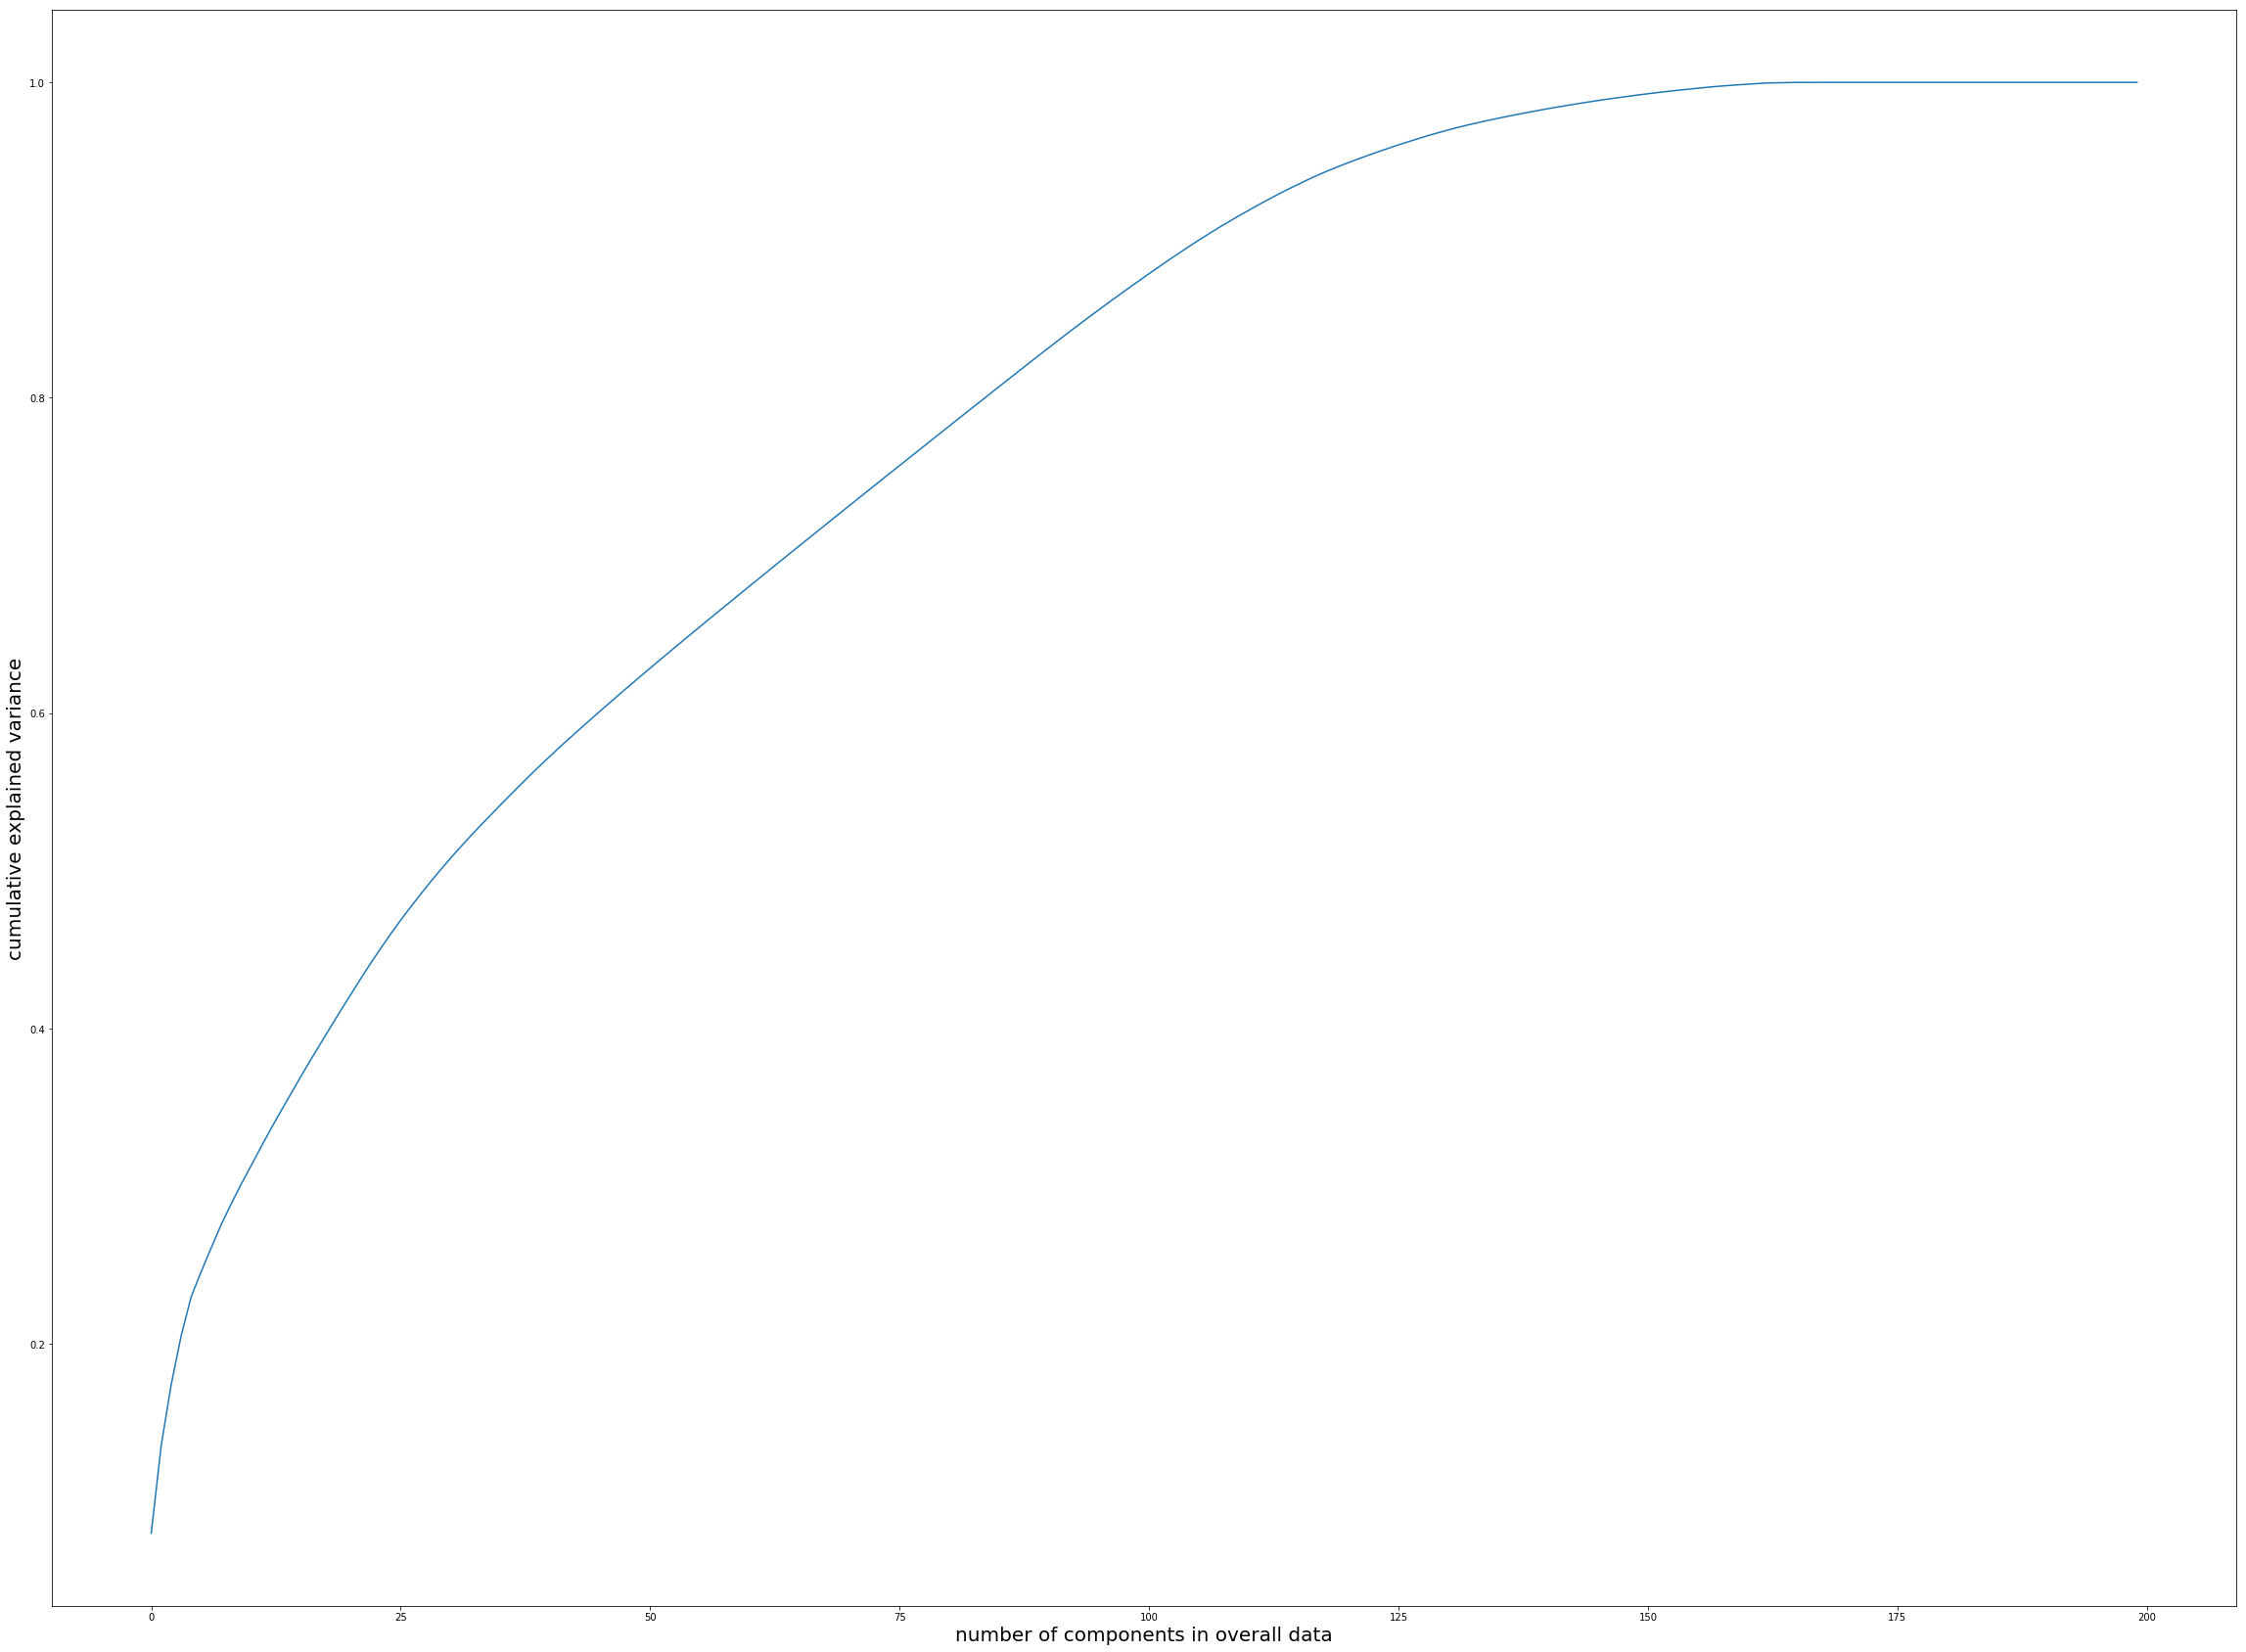

In [246]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(40, 30))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components in overall data', fontsize=20);
plt.ylabel('cumulative explained variance', fontsize=20);
plt.tick_params(axis='both', which='minor', labelsize=20)


In [247]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=50)
pca.fit(azdias_scaled)
pca_data = pca.transform(azdias_scaled)

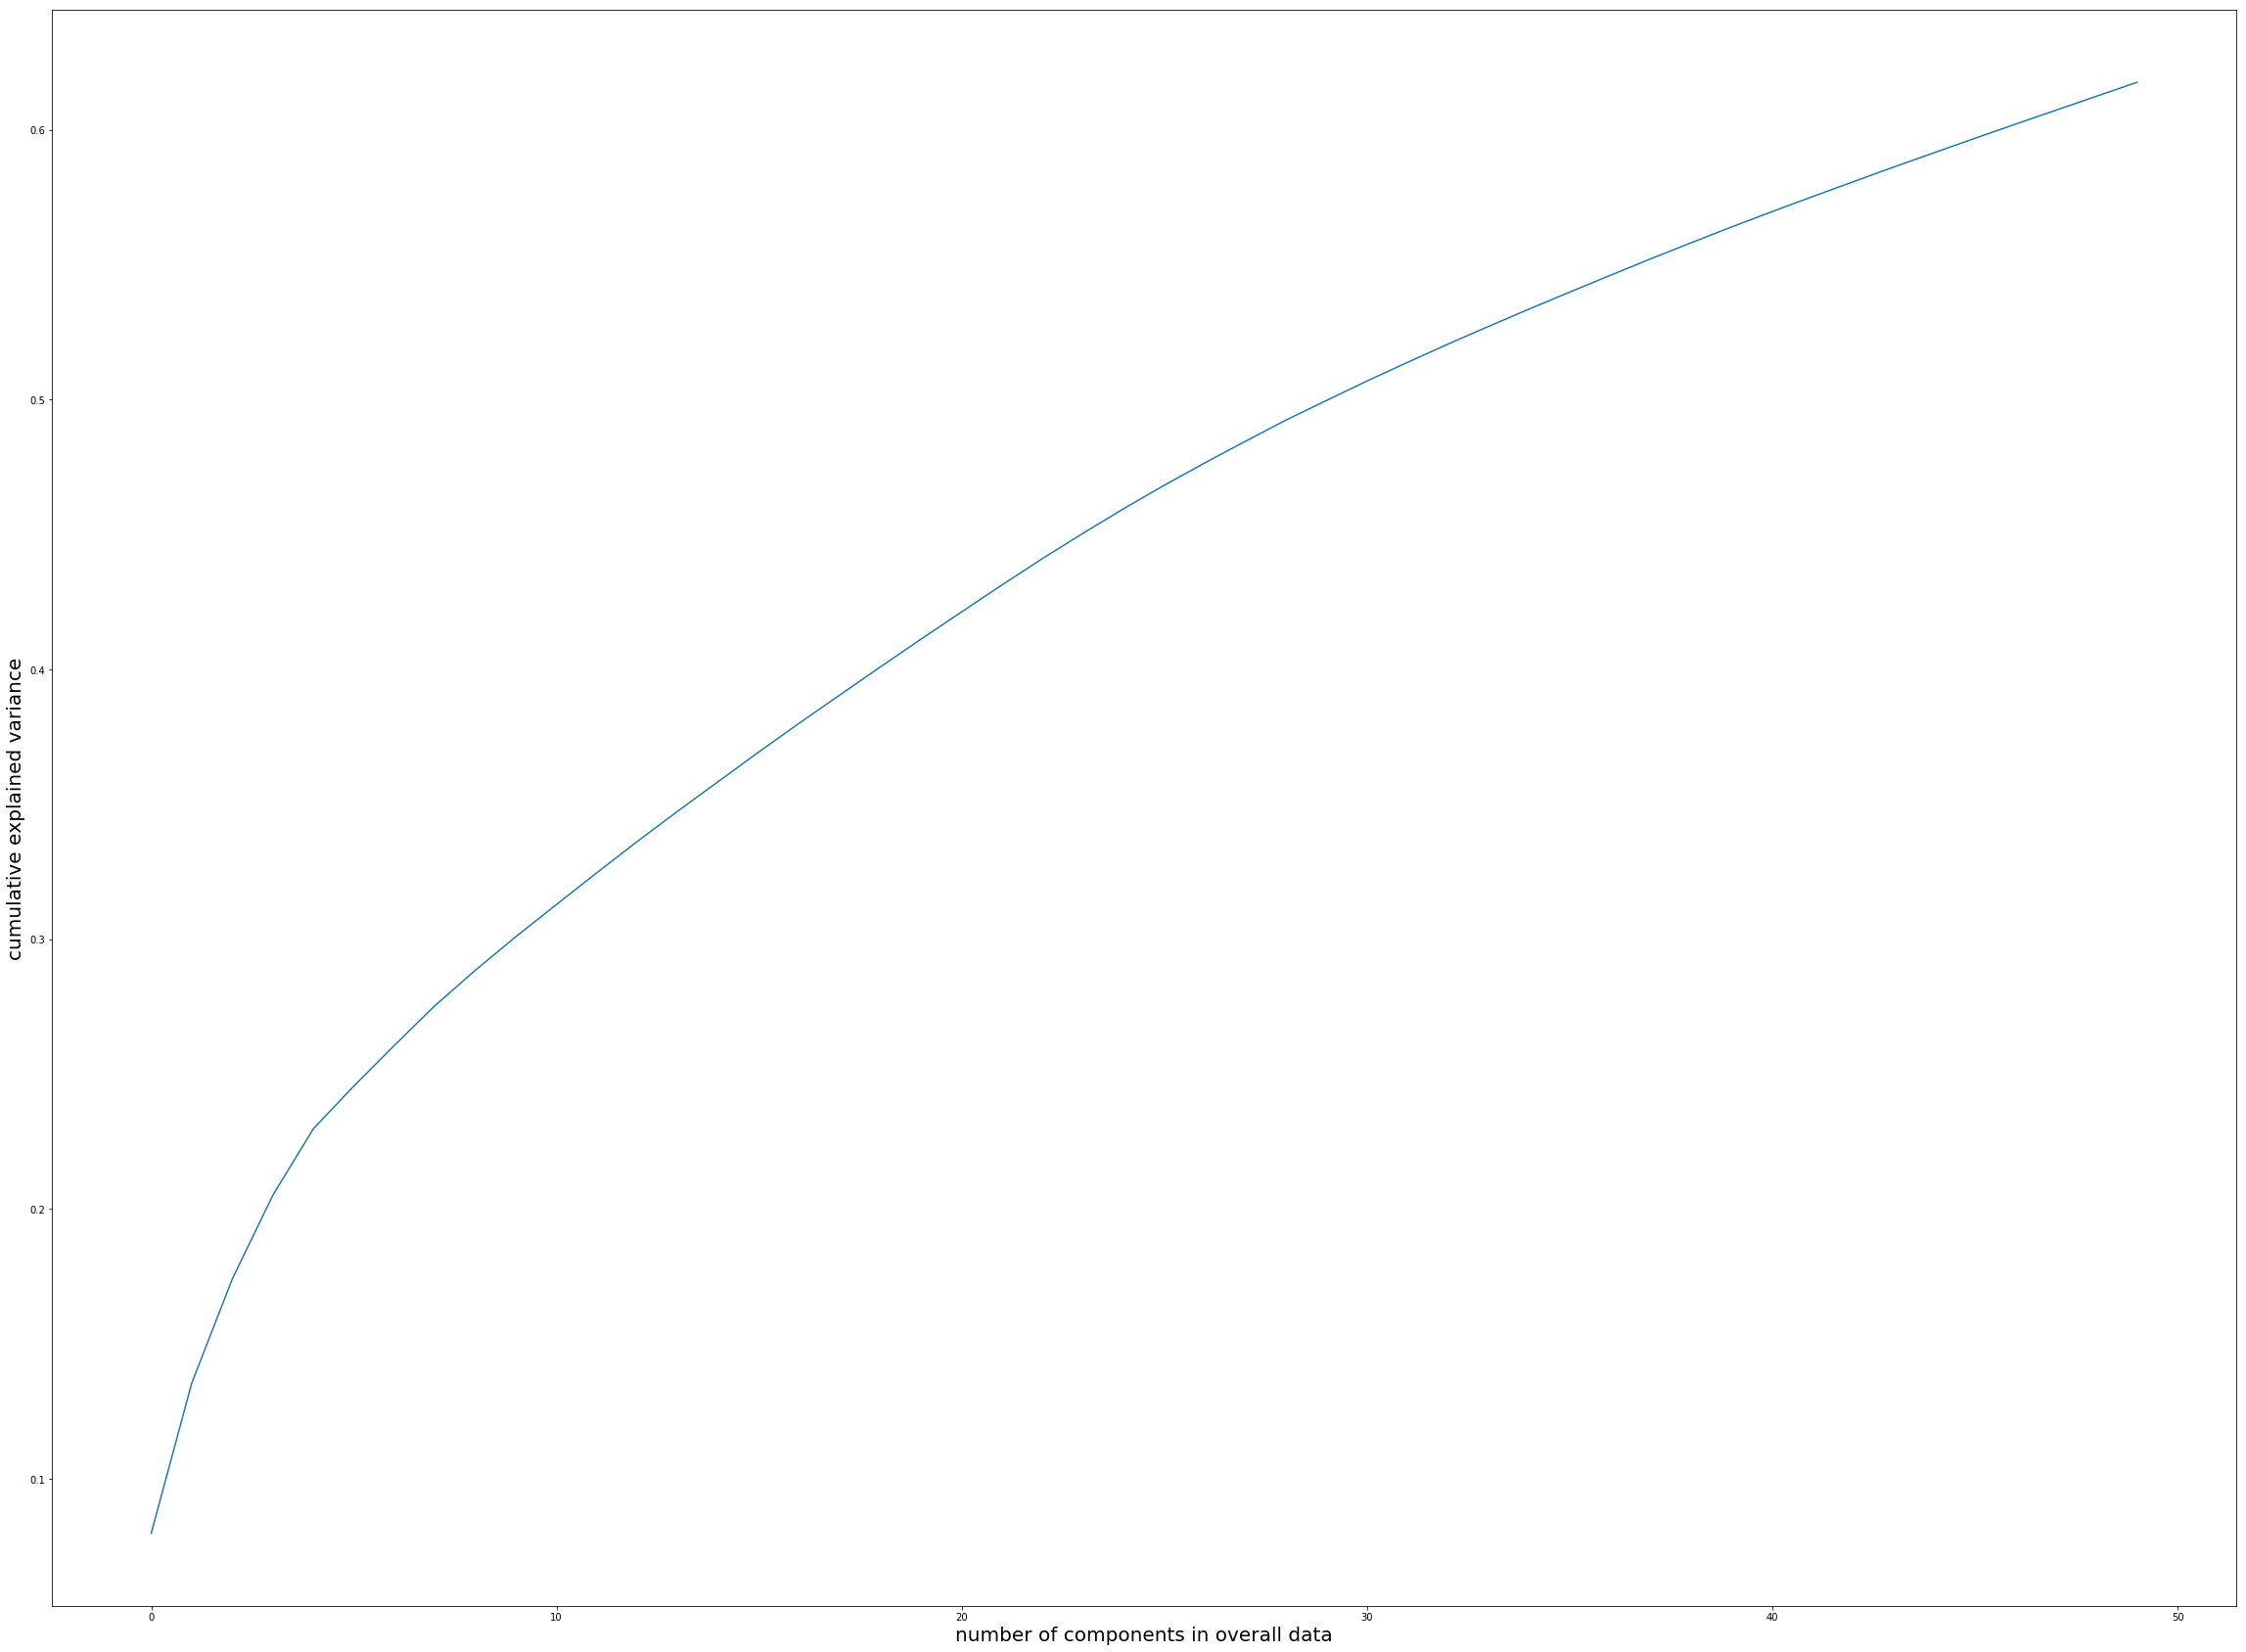

In [248]:
plt.figure(figsize=(40, 30))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components in overall data', fontsize=20);
plt.ylabel('cumulative explained variance', fontsize=20);
plt.tick_params(axis='both', which='minor', labelsize=20)

### Discussion 2.2: Perform Dimensionality Reduction

PCA with all of the Principal Components showed that the first 6 Principal Components each explain more than 3% of the total variance. The first 15 Principal Components explain 40% of all the variance. I am retaining 50 Prinicpal Components for the analysis, as they explain > 60% variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [251]:
df_comp=pd.DataFrame (pca.components_)
df_comp.columns = azdias_scaled.columns
df_comp

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL,RURAL
0,-0.075316,-0.185363,0.106473,-0.076779,0.050776,0.045467,0.148225,0.031401,-0.145425,-0.132844,...,0.036346,0.055536,0.056099,0.055570,0.017608,-0.110035,0.069862,-0.105138,0.179156,-0.107450
1,0.234313,0.092576,-0.229808,0.219818,-0.201945,-0.215205,0.081304,-0.054925,-0.043643,-0.051943,...,-0.008236,0.000086,0.003637,0.009439,0.037703,-0.003732,-0.231643,0.017321,0.048065,-0.041694
2,0.024673,0.119890,-0.056279,0.049428,-0.149704,-0.049593,-0.051929,-0.011990,0.002062,-0.000658,...,-0.002324,0.013506,0.024681,0.012422,-0.000533,0.072628,-0.057001,-0.016042,0.023725,-0.051572
3,-0.021738,-0.016487,0.012308,-0.009607,-0.049678,0.039757,-0.005393,-0.004970,0.174565,0.177674,...,0.008540,0.002447,0.010525,0.006638,0.002601,0.248362,0.023168,0.006659,-0.017583,-0.183120
4,0.047169,0.021738,-0.030935,0.031785,0.025579,-0.103914,0.010352,-0.011350,0.267207,0.283225,...,0.048870,0.033282,0.015069,0.016459,0.001158,-0.183678,-0.030938,-0.054871,0.114589,0.043442
5,-0.001832,-0.133466,0.011933,0.048188,0.012343,0.018435,0.199917,-0.043135,0.062196,0.076802,...,-0.028357,-0.066072,-0.048433,-0.049174,0.017488,-0.020947,-0.023799,0.040264,0.017957,0.099022
6,-0.026307,-0.016307,0.008613,-0.114369,0.094068,-0.095535,0.100669,-0.055580,-0.024989,-0.033153,...,-0.038554,0.041063,-0.019735,-0.070085,0.002192,0.076283,0.004429,0.153444,-0.025040,0.068914
7,0.021679,0.056185,-0.019710,-0.035773,-0.032673,0.005581,-0.104568,0.014947,-0.011702,-0.000917,...,-0.016649,0.022465,0.044064,0.010082,0.073228,-0.040636,0.027501,-0.059021,-0.066774,0.071602
8,0.024803,0.008002,-0.037486,0.009422,-0.064937,0.030664,-0.016842,-0.079913,-0.015556,-0.056332,...,-0.071340,-0.107147,-0.101344,-0.097753,-0.030030,-0.020824,-0.010887,0.092887,0.030861,-0.013065
9,-0.001801,-0.063493,0.004780,0.032596,0.008410,0.039909,0.108557,-0.162748,-0.018456,-0.020466,...,0.052758,0.027134,0.043261,0.064967,0.078367,-0.028070,-0.040676,0.027584,-0.052232,0.038815


In [252]:
def pc_feat (item, df):
    sorted_df = df.sort_values(df.index [item], axis=1)
      
    return sorted_df.iloc [[item]]

In [256]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

(pc_feat (0,df_comp))

,FINANZ_MINIMALIST,MOBI_REGIO,PLZ8_ANTG1,KBA05_GBZ,KBA05_ANTG1,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,KONSUMNAEHE,PLZ8_GBZ,INNENSTADT,...,KBA05_ANTG4,LP_STATUS_FEIN_1.0,EWDICHTE,FINANZ_HAUSBAUER,ORTSGR_KLS9,PLZ8_ANTG4,PLZ8_ANTG3,CAMEO_INTL_2015_WL,HH_EINKOMMEN_SCORE,LP_STATUS_GROB_1.0
0,-0.185363,-0.182476,-0.175823,-0.175657,-0.175562,-0.145425,-0.132844,-0.131015,-0.127719,-0.121762,...,0.125273,0.126107,0.146807,0.148225,0.148972,0.168188,0.174493,0.179156,0.184104,0.191728


In [257]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

(pc_feat (1,df_comp))


,PRAEGENDE_JUGENDJAHRE_DC,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_ANLEGER,SEMIO_KULT,SEMIO_RAT,ONLINE_AFFINITAET,...,FINANZTYP_5,FINANZTYP_2,CJT_GESAMTTYP_2.0,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,ZABEOTYP_3,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
1,-0.231643,-0.229808,-0.220074,-0.215205,-0.208194,-0.20766,-0.201945,-0.17254,-0.166639,-0.160172,...,0.094175,0.095484,0.110978,0.122396,0.152698,0.163332,0.18594,0.200355,0.219818,0.234313


In [258]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

(pc_feat (2,df_comp))


,ANREDE_KZ_2,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,SEMIO_RAT,FINANZ_ANLEGER,FINANZTYP_1,SHOPPER_TYP_2.0,LP_STATUS_FEIN_2.0,...,SEMIO_REL,ZABEOTYP_1,SHOPPER_TYP_0.0,FINANZ_MINIMALIST,FINANZTYP_5,SEMIO_KULT,SEMIO_SOZ,SEMIO_FAM,SEMIO_VERT,ANREDE_KZ_1
2,-0.328046,-0.29462,-0.263215,-0.246254,-0.188669,-0.154221,-0.149704,-0.095005,-0.082061,-0.074081,...,0.096908,0.101753,0.110164,0.11989,0.129258,0.231618,0.238845,0.239975,0.300142,0.328046


### Discussion 2.3: Interpret Principal Components

Principal component 1. 

Prominent features are: 
Negative: FINANZ_MINIMALIST, MOBI_REGIO, PLZ8_ANTG1

Positive: LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_WL

From above I can presume that such factors as the most crucial such as movement level in the region, number of 1-2 houses in the microcell and region, social status, income, number 6-10 family houses in the region and wealth. It appears that the increases in 1-2 family houses will lead to decreases 6-10 family houses which is logical and confirmed by PCA. Increases in number of 1-2 family in microcell affects in increases of 1-2 family in the region.  

Principal component 2. 

Prominent features are: 
Negative: PRAEGENDE_JUGENDJAHRE_DC, FINANZ_SPARER, SEMIO_REL

Positive: ALTERSKATEGORIE_GROB, FINANZ_VORSORGER ,ZABEOTYP_3

From above I can presume that such factors as the most crucial such as youth in decades/age, financial typology, religious factor and energey consumption typology. It is also visible here that the more increases money saver then be prepared decreases as they are negatively correlated between each other.

Principal component 3. 

Prominent features are: 
Negative: ANREDE_KZ_2, SEMIO_KAEM, SEMIO_DOM

Positive: ANREDE_KZ_1, SEMIO_VERT, SEMIO_FAM

Both gender and personal typology closely related to each other being characteristic of a human. From the same negative direction we can see their correlation: gender factor, combative-dominant are in syncronization where factors increase together.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [259]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data)) #absolute value taken
    
    return score

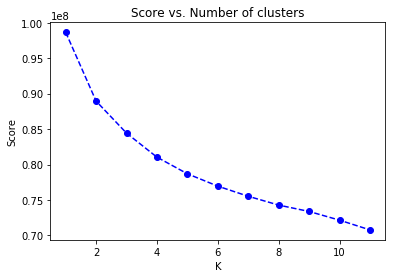

In [260]:
scores = []
centers = list(range(1,12))

for center in centers:
    scores.append(get_kmeans_score(pca_data, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');

In [298]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans (n_clusters = 7) 
model = kmeans.fit (pca_data) #fitting to the data

azdias_clust = model.predict (pca_data)

### Discussion 3.1: Apply Clustering to General Population

Plotted k vs scores for a number of k values and using elbow method I decided that 7 clusters should be a good choice as the graph is slope of the graph becomes less after it. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [281]:
# Load in the customer demographics data.
customers = pd.read_csv ('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [282]:
customers.head (n=5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [288]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers, feat_info)

ANREDE_KZ


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([1, 2])

CJT_GESAMTTYP


array([  5.,   2.,   6.,   4.,   1.,   3.,  nan])

FINANZTYP


array([2, 6, 5, 3, 1, 4])

GFK_URLAUBERTYP


array([  4.,   3.,  10.,   2.,  11.,   8.,   1.,   5.,   9.,  12.,   7.,
         6.,  nan])

GREEN_AVANTGARDE


array([1, 0])

LP_FAMILIE_FEIN


array([  2.,   1.,  nan,  10.,   8.,   6.,  11.,   9.,   7.,   5.,   3.,
         4.])

LP_FAMILIE_GROB


array([  2.,   1.,  nan,   5.,   4.,   3.])

LP_STATUS_FEIN


array([ 10.,   9.,   1.,   7.,   6.,   3.,   8.,   5.,   4.,   2.,  nan])

LP_STATUS_GROB


array([  5.,   4.,   1.,   3.,   2.,  nan])

NATIONALITAET_KZ


array([  1.,   2.,  nan,   3.])

SHOPPER_TYP


array([  3.,   1.,   0.,   2.,  nan])

SOHO_KZ


array([ 0.,  1.])

VERS_TYP


array([  1.,   2.,  nan])

ZABEOTYP


array([3, 1, 2, 4, 6, 5])

GEBAEUDETYP


array([ 1.,  8.,  2.,  3.,  4.,  6.])

OST_WEST_KZ


array([ 1.,  0.])

CAMEO_DEUG_2015


array(['1', '5', '4', '7', '3', '9', '2', '6', '8', nan], dtype=object)

CAMEO_DEU_2015


array(['1A', '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B', '9D',
       '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D', '2A',
       '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E', '5E',
       '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F', nan,
       '4D'], dtype=object)

In [290]:
customers_cleaned['GEBAEUDETYP_5.0'] = 0

In [291]:
customers_cleaned.shape

(141640, 200)

In [292]:
azdias_scaled.shape

(797426, 200)

In [293]:
customer_pca = pca.transform(scaler.transform(imputer.transform(customers_cleaned)))

customer_kmeans = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67afe1c6a0>]], dtype=object)

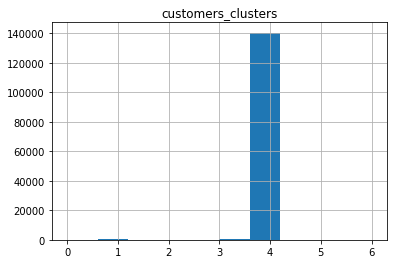

In [319]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
gen_pop = azdias_scaled.shape[0]
gen_pop_all = azdias.shape[0] #including all dropped high NaN data

customer_pop = customers_cleaned.shape[0]
customer_pop_all = customers.shape[0] #including all customers with high NaN data

gen_pop_cluster_count = np.bincount(azdias_clust)
customer_cluster_count = np.bincount(customer_kmeans)

gen_pop_cluster_prop = [x/gen_pop for x in gen_pop_cluster_count]
customer_cluster_prop = [x/customer_pop for x in customer_cluster_count]

cust_cldf = pd.DataFrame (customer_kmeans, columns = ['customers_clusters'])

cust_cldf.hist ()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67a6028cc0>]], dtype=object)

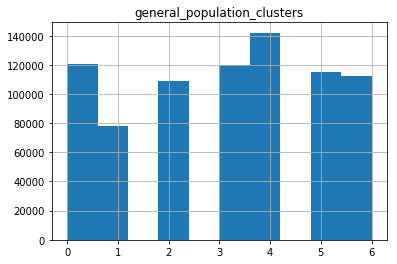

In [320]:
azdias_cldf = pd.DataFrame (azdias_clust, columns = ['general_population_clusters'])

azdias_cldf.hist ()

In [301]:
prop_data = pd.DataFrame({'gen_pop': gen_pop_cluster_prop, 'customers': customer_cluster_prop}, index=np.arange(1,8))
prop_data.index.names=['Cluster']

In [322]:
azdias_clust_inv = pd.DataFrame (azdias_clust, columns = ['clusters'])
azdias_clust_inv.index = azdias_scaled.index #restoring indeces
display (azdias_clust_inv.tail (n=10))
print (azdias_clust_inv.shape)

,clusters
891211,5
891212,5
891213,0
891214,2
891215,2
891216,2
891217,5
891218,6
891219,1
891220,5


(797426, 1)


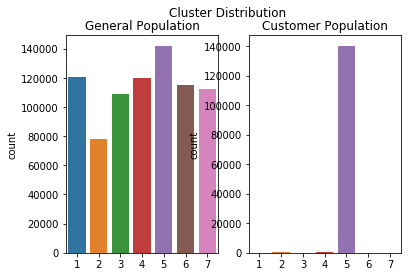

In [315]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
plt.figure(figsize=(15,6)) # this creates a figure 14 inch wide, 4 inch high
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False)
fig.suptitle('Cluster Distribution')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.countplot(azdias_clust+1, ax=ax1)
sns.countplot(customer_kmeans+1, ax=ax2)
plt.show()

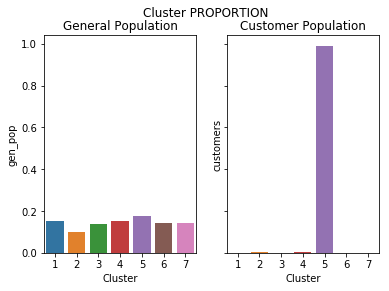

In [314]:
plt.figure(figsize=(15,5)) # this creates a figure 14 inch wide, 4 inch high
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle('Cluster PROPORTION')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.barplot(x=prop_data.index, y=prop_data.gen_pop, ax=ax1)
sns.barplot(x=prop_data.index, y=prop_data.customers, ax=ax2)
plt.show()

In [317]:
rep = {}

print('Cluster Representation')
for i in np.arange(0,7):
    a = customer_cluster_prop[i]
    b = gen_pop_cluster_prop[i]
    rep[i+1] = (a-b)*100

for x in rep:
    print('Cluster %s: represented by %.4f%%'% (x, rep[x]))

Cluster Representation
Cluster 1: represented by -14.9967%
Cluster 2: represented by -9.5620%
Cluster 3: represented by -13.6239%
Cluster 4: represented by -14.7997%
Cluster 5: represented by 81.2848%
Cluster 6: represented by -14.3290%
Cluster 7: represented by -13.9735%


In [318]:
full_rep = {}

print('Cluster Over Representation')
for i in np.arange(0,7):
    a = prop_data_all.customers.iloc[i]
    b = prop_data_all.gen_pop.iloc[i]
    full_rep[i+1] = (a-b)*100

for x in full_rep:
    print('Cluster %s: represented by %.4f%%'% (x, full_rep[x]))


Cluster Over Representation
Cluster 1: represented by -13.4359%
Cluster 2: represented by -8.5939%
Cluster 3: represented by -12.1916%
Cluster 4: represented by -13.2837%
Cluster 5: represented by 57.2995%
Cluster 6: represented by -12.8421%
Cluster 7: represented by -12.5232%


In [352]:
def cluster_centers(cluster):
    cluster_center = np.around(kmeans.cluster_centers_[cluster-1], decimals=2)
    clusters_sorted = cluster_center[np.argsort(cluster_center)[:]]
    pca_undone=np.around(pca.inverse_transform(kmeans.cluster_centers_[cluster-1]), 
                                                 decimals=2)
    pca_undone_sorted = pca_undone[np.argsort(pca_undone)[:]]
    print('Cluster %s' % cluster)
    print('sort list\n-----\n First 3: %s \n Last 3: %s '% (np.flip(clusters_sorted[-3:],0), 
                                                               clusters_sorted[:3]))
    print('\n original list\n-----\n %s'% cluster_center)
    
    print('PCA sort\n-----\n First 3: %s \n Last 3: %s '% (np.flip(pca_undone_sorted[-3:],0), 
                                                               pca_undone_sorted[:3]))
    print('\n PCA Inverse\n-----\n %s'% pca_undone)

In [354]:
cluster_centers(cluster=2)

Cluster 2
sort list
-----
 First 3: [ 4.03  2.92  0.26] 
 Last 3: [-3.26 -0.53 -0.42] 

 original list
-----
 [ 4.03 -3.26  2.92 -0.42 -0.14  0.11  0.18 -0.3  -0.16  0.21 -0.18  0.15
  0.05  0.09  0.12 -0.1   0.2  -0.53 -0.1  -0.17  0.14 -0.06 -0.17  0.26
  0.    0.24 -0.03 -0.34 -0.1  -0.33  0.2   0.05  0.04 -0.19  0.13 -0.16
 -0.35 -0.16 -0.16 -0.23  0.01 -0.06 -0.15  0.    0.01  0.02 -0.03 -0.1   0.
 -0.06]
PCA sort
-----
 First 3: [ 1.36  1.34  1.17] 
 Last 3: [-1.27 -1.1  -1.05] 

 PCA Inverse
-----
 [-0.88 -0.81  1.14 -1.05  0.54  0.9   0.28  0.15 -0.53 -0.46 -0.5   1.15
  1.34  1.17  0.68  0.89 -0.58 -1.27  1.36  0.13 -0.98 -0.94 -1.    0.74
  0.61 -0.27 -0.02  0.63  0.14 -0.46  0.37  0.09 -0.48 -0.16 -0.61  0.14
  0.43  0.36 -0.58 -0.32  0.49 -0.45 -0.35  0.18 -0.63  0.17  0.18 -0.17
 -0.63  0.43  0.63  0.6   0.16 -0.43  0.41  0.52  0.36  1.1  -1.1  -0.35
 -0.46  0.34  0.52  0.   -0.2   0.72 -0.48 -0.    0.5  -0.16 -0.47  0.01
 -0.1  -0.19 -0.09 -0.13 -0.12 -0.17 -0.01  0.11 -0

In [355]:
cluster_centers(cluster=3)

Cluster 3
sort list
-----
 First 3: [ 4.59  0.8   0.59] 
 Last 3: [-2.61 -2.15 -0.4 ] 

 original list
-----
 [ 4.59 -2.15 -2.61  0.8  -0.35 -0.1  -0.03 -0.25 -0.28  0.59  0.28 -0.34
 -0.15  0.11  0.13 -0.05  0.03 -0.28  0.09  0.05  0.   -0.1   0.1  -0.4
  0.16  0.28  0.1  -0.01  0.24  0.16 -0.09 -0.2  -0.2  -0.02 -0.18  0.1
  0.05 -0.03 -0.21  0.11 -0.11 -0.14  0.14  0.07 -0.01  0.05 -0.02  0.02
  0.02 -0.03]
PCA sort
-----
 First 3: [ 1.38  1.28  1.22] 
 Last 3: [-1.38 -1.03 -0.97] 

 PCA Inverse
-----
 [-0.97 -1.38  1.13 -0.85  1.02  0.82  0.8   0.18 -0.54 -0.44 -0.59 -0.47
 -0.13  0.68  0.38 -1.03 -0.55 -0.12 -0.06  1.22  0.53  0.83  0.92  0.98
  0.87 -0.25 -0.03  0.71 -0.01 -0.37  0.34  0.05 -0.48 -0.23 -0.59  0.13
  0.46  0.38 -0.6  -0.3   0.54 -0.42 -0.3   0.08 -0.61  0.15  0.13 -0.18
 -0.6   0.44  0.62  0.59  0.17 -0.4   0.37  0.55  0.36 -0.95  0.95 -0.27
 -0.3   0.11 -0.03  0.25  0.25  1.28 -0.34 -0.19 -0.09 -0.39 -0.5  -0.03
 -0.09 -0.08 -0.15 -0.15 -0.12 -0.16 -0.03  0.12 -0

In [356]:
cluster_centers(cluster=4)

Cluster 4
sort list
-----
 First 3: [ 4.11  2.07  0.39] 
 Last 3: [-1.89 -0.23 -0.21] 

 original list
-----
 [ 2.07  4.11 -1.89  0.34  0.19  0.39 -0.01  0.02  0.24 -0.23 -0.21  0.1
  0.16  0.04 -0.11 -0.07 -0.01  0.06 -0.09 -0.18  0.04  0.02 -0.06  0.16
  0.01 -0.16 -0.1   0.04 -0.02  0.07  0.09  0.03  0.07  0.07  0.09 -0.11
 -0.01 -0.04  0.09 -0.18  0.05  0.15 -0.21 -0.07  0.07 -0.14 -0.08  0.04
  0.    0.12]
PCA sort
-----
 First 3: [ 1.04  0.91  0.91] 
 Last 3: [-1.13 -1.01 -0.98] 

 PCA Inverse
-----
 [ 0.74 -0.31 -0.61  0.65 -0.45 -0.67  0.76 -0.19 -0.35 -0.35  0.47 -0.65
 -0.98 -1.01 -0.63 -0.78  0.47  1.04 -1.13 -0.29  0.81  0.71  0.91 -0.69
 -0.72 -0.33 -0.03  0.58  0.35  0.1   0.37  0.13 -0.4  -0.17 -0.58  0.09
  0.39  0.41 -0.62 -0.26  0.45 -0.34 -0.25  0.06 -0.6  -0.7   0.1  -0.1
 -0.54  0.43  0.56  0.5   0.14 -0.35  0.31  0.43  0.32 -0.88  0.88  0.22
  0.44 -0.14 -0.11 -0.2  -0.2  -0.17  0.25 -0.41 -0.29  0.12  0.25 -0.15
 -0.14  0.1   0.27  0.03 -0.05  0.01  0.15 -0.16  0

In [357]:
cluster_centers(cluster=5)

Cluster 5
sort list
-----
 First 3: [ 1.06  1.    0.53] 
 Last 3: [-3.82 -2.46 -0.42] 

 original list
-----
 [-3.82  1.   -0.42 -2.46  1.06 -0.32 -0.24  0.41 -0.17  0.01  0.43 -0.35
 -0.08 -0.13 -0.09  0.31 -0.14 -0.14  0.09 -0.16 -0.08  0.06 -0.01 -0.05
  0.04  0.53  0.08  0.12  0.09 -0.02 -0.12 -0.05 -0.04 -0.   -0.08 -0.04
 -0.1  -0.14 -0.17 -0.07 -0.04 -0.03  0.03  0.05  0.    0.03  0.02 -0.03
 -0.03 -0.01]
PCA sort
-----
 First 3: [ 1.4   1.37  0.94] 
 Last 3: [-0.94 -0.93 -0.84] 

 PCA Inverse
-----
 [ 0.57  0.94 -0.7   0.57 -0.24 -0.58 -0.55 -0.09  0.36  0.32  0.18 -0.19
 -0.29 -0.46 -0.4   0.15  0.28  0.35 -0.25 -0.46 -0.   -0.22 -0.19 -0.48
 -0.48  0.14 -0.03 -0.4   0.04  0.21 -0.41 -0.09  0.66  0.23  0.67 -0.12
 -0.51 -0.47  0.75  0.6  -0.93  0.69  0.38  0.22  0.74 -0.07  0.1   0.1
  0.72 -0.65 -0.84 -0.75 -0.36  0.39 -0.54 -0.94 -0.57  0.09 -0.09  0.1
  0.38 -0.04 -0.1  -0.09 -0.25 -0.61  0.48  0.09 -0.25 -0.17  0.42  0.14
 -0.01  0.01 -0.05  0.15  0.2   0.28 -0.13 -0.06 -0

In [358]:
cluster_centers(cluster=6)

Cluster 6
sort list
-----
 First 3: [ 3.05  2.34  2.25] 
 Last 3: [-0.44 -0.42 -0.39] 

 original list
-----
 [ 2.34  2.25  3.05 -0.42  0.53  0.24 -0.32  0.08  0.39 -0.44  0.03  0.09
  0.   -0.09 -0.2  -0.01 -0.19  0.52  0.17  0.19 -0.03  0.09  0.1   0.01
  0.01 -0.39 -0.19  0.01  0.01  0.07 -0.17 -0.    0.06  0.03 -0.02  0.15
  0.23  0.19  0.08  0.17 -0.03 -0.02  0.11  0.06 -0.05  0.06  0.05 -0.01
  0.07 -0.12]
PCA sort
-----
 First 3: [ 0.95  0.83  0.82] 
 Last 3: [-0.95 -0.87 -0.72] 

 PCA Inverse
-----
 [ 0.46  0.18 -0.54  0.59 -0.87 -0.69  0.31  0.12 -0.35 -0.35  0.74  0.56
  0.58 -0.02  0.16  0.8   0.3  -0.24  0.47 -0.7  -0.47 -0.65 -0.72 -0.38
 -0.4  -0.3   0.02  0.57  0.4   0.11  0.38  0.09 -0.46 -0.19 -0.68  0.12
  0.5   0.42 -0.67 -0.38  0.58 -0.45 -0.31  0.02 -0.67 -0.58  0.1  -0.17
 -0.62  0.47  0.63  0.58  0.14 -0.42  0.41  0.57  0.42  0.95 -0.95  0.29
 -0.1  -0.1  -0.1   0.03  0.05 -0.51 -0.24 -0.26 -0.21  0.82  0.28 -0.1
 -0.11  0.01  0.22 -0.   -0.03 -0.14  0.12 -0.25  

In [359]:
cluster_centers(cluster=7)

Cluster 7
sort list
-----
 First 3: [ 0.53  0.5   0.39] 
 Last 3: [-4.16 -1.96 -1.17] 

 original list
-----
 [-1.96 -4.16 -1.17 -0.72 -0.07  0.5   0.14  0.34  0.53 -0.21 -0.27  0.11
  0.2  -0.12 -0.06  0.31 -0.05  0.28 -0.27 -0.25 -0.17  0.28  0.19  0.39
 -0.08 -0.23  0.05  0.16 -0.26  0.06  0.16  0.28  0.2   0.11  0.2   0.02
  0.17  0.2   0.33  0.04  0.15  0.15  0.05 -0.16 -0.01 -0.05  0.05  0.09
 -0.04  0.06]
PCA sort
-----
 First 3: [ 0.97  0.93  0.92] 
 Last 3: [-0.89 -0.83 -0.71] 

 PCA Inverse
-----
 [-0.83 -0.23  0.81 -0.89  0.93  0.97 -0.56  0.08  0.32  0.32 -0.65 -0.01
  0.26  0.64  0.45 -0.07 -0.57 -0.47  0.36  0.7  -0.07 -0.01 -0.1   0.69
  0.77  0.37 -0.03 -0.4  -0.67 -0.12 -0.38 -0.15  0.57  0.44  0.48 -0.14
 -0.45 -0.4   0.57  0.43 -0.71  0.56  0.33  0.02  0.5   0.72 -0.    0.23
  0.67 -0.52 -0.71 -0.68 -0.19  0.46 -0.5  -0.71 -0.46 -0.11  0.11 -0.15
 -0.39 -0.01  0.11  0.13  0.31  0.31 -0.33  0.43  0.72 -0.44 -0.32  0.09
  0.42 -0.07 -0.17 -0.15 -0.06 -0.17 -0.2   0.44 

### Discussion 3.3: Compare Customer Data to Demographics Data
During the time when we included complete population for all features (including dropped features) for analysis, the culsters: '5','2','4' were the most over represented in the customer data compared to the general population data ('57.2995%', '8.5939%', '13.2837%'. These percentages were higher for low-NaN data. Based on the full general population data.

The must under represented clusterds compared to compltete population data were '1', '3', '6', '7' clusters respectively.

In order to see the features that defined every cluster the maximum, We took inverse transf of the Pricipal Components that gave me back original features, using a standard scale. We did this becacause it was easeier to interpret and understand than the principal components.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.